# Analysis fastReach 

## general prep

In [1]:

# load packages
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
# %load_ext rpy2.ipython # currently not needed
import glob

from wordcloud import WordCloud, STOPWORDS
#from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pymer4 as pymer4
   


In [22]:
# set path
d = "C://Users/terfu/Desktop/2021-fastReach/analyses/Leonie_tests/" # for test data

p = "//stor1.bpn.tu-berlin.de/projects/Lukas_Gehrke/2021-fastReach/data/study/" #server for data access
pp = "C://Users/terfu/Desktop/2021-fastReach/data/study/" #repository for output

## load functions

plot with 2 categories

In [10]:
# plot with two cats
def plot_2_cats(data, x, y, hue, ylabel, xlabel,cats,palette):
    
    cats_0 = data[data[x]==cats[0]]
    cats_1 = data[data[x]==cats[1]]

    pairs = [(cats[0], cats[1])]

    ###  get p values for paired t test between two conditions

    pvalues = [
        stats.ttest_rel( cats_0[y], cats_1[y]).pvalue
        #stats.ranksums(cat_0[dv], cat_1[dv]).pvalue
    ]
    
    # Transform each p-value to "p=" in scientific notation
    formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues]

    with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(3,5))
        fig.patch.set_alpha(1)

        

        sns.despine() #bottom=True, left=True
        # show boxplots
        ax = sns.boxplot(data = data,x = x, y = y,  palette= [palette[0]*len(pairs)])
        for patch in ax.patches: # adapt alpha
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .6))

        #  show lines connecting pid means observations    
        sns.lineplot(data = data, x = x, y = y, 
                    legend = False, linewidth = 0.5, linestyle = '-',ci =None,color = palette[2], alpha=0.8)
        2

        #Show mean observation with a scatterplot
        sns.stripplot(data = data,x = x, y = y, hue = None,size=8,
                    label=None, marker="s",s = 6, color = palette[2], alpha=0.8)

    
        # show line connecting means
        sns.pointplot(
            data = data,x = x, y = y,
            markers="s", size = 6, ci =None,color = palette[0])


        # Add annotations
        annotator = Annotator(ax, pairs = [(cats[0], cats[1])], data = data,x = x, y = y)
        annotator.configure(text_format="simple")
        annotator.set_pvalues(pvalues)
        annotator.annotate()

        # Label and show
        # label_plot_for_subcats(ax)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

        plt.show()

        fig.savefig('results/'+ title + '_' + ylabel + '_' + xlabel + '.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
        fig.savefig('results/'+ title + '_' + ylabel + '_' + xlabel + '.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

plot with three categories

In [6]:
# plot with three condition 

def plot_3_cats(data, x, y, hue, ylabel, xlabel,cats,palette,data_means):
    
    cats_0 = data[data[x]==cats[0]]
    cats_1 = data[data[x]==cats[1]]
    cats_2 = data[data[x]==cats[2]]

    pairs = [(cats[0], cats[1],cats[1])]

    

    with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(3,5))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True
         # show boxplots
        ax = sns.boxplot(data = data,x = x, y = y,  palette= [palette[0]*len(pairs)])
        for patch in ax.patches: # adapt alpha
             r, g, b, a = patch.get_facecolor()
             patch.set_facecolor((r, g, b, .6))

        #  show lines connecting pid means observations    
        sns.lineplot(data = data_means, x = x, y = y, hue = hue,
                      legend = False, linewidth = 0.5, linestyle = '-',ci =None,color = palette[2], alpha=0.8)
        2

            
        # show line connecting means
        sns.pointplot(
            data = data,x = x, y = y,
            markers="s", size = 6, ci =None,color = palette[0],legend = True)


        
        # Label and show
        # label_plot_for_subcats(ax)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

        plt.show()

        fig.savefig('results/'+ title + '_' + ylabel + '_' + xlabel + '.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
        fig.savefig('results/'+title + '_' + ylabel + '_' + xlabel + '.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

plot with 3 categories and hue

In [7]:
# plot with three condition 

def plot_3_cats_hue(data, x, y, hue, ylabel, xlabel,cats,palette,data_means,hue2):
    
    cats_0 = data[data[x]==cats[0]]
    cats_1 = data[data[x]==cats[1]]
    cats_2 = data[data[x]==cats[2]]

    pairs = [(cats[0], cats[1],cats[1])]

   
    with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(6,5))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True

         # show boxplots
        ax = sns.boxplot(data = data,x = x, y = y, hue = hue2,  palette= palette[3:6])
        for patch in ax.patches: # adapt alpha
             r, g, b, a = patch.get_facecolor()
             patch.set_facecolor((r, g, b, .6))
    
         # show line connecting menas
        ax = sns.pointplot(
            data = data,x = x, y = y, dodge=.8 - .8 / 3,
            markers=['s','o','^'],linestyles = ['solid','dotted','dashed'],hue = hue2, size = 6, ci =None,palette= palette[3:6], labels = True)
        

        handles, labels = ax.get_legend_handles_labels()  
       
        plt.legend(handles[3:6],labels[3:6],frameon=True,loc = 'upper left',labelspacing =0.3)
        
        # label_plot_for_subcats(ax)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        
        plt.show()

        fig.savefig('results/'+ title + '_' + ylabel + '_' + xlabel + '.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
        fig.savefig('results/'+title + '_' + ylabel + '_' + xlabel + '.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

plot eeg timeline

In [8]:
# plot eeg data with in timeline with 3 conditions

def plot_erp_timeline(data,id_vars, delete_vars, sample_rate,window_start,hue,palette,title):

     with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(9,5))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True 
        # prep data
        # remove unnesseary columns 
        data = data.loc[:,data.columns!= delete_vars]

         # to long format

        data_long = pd.melt(data, id_vars= id_vars, var_name='timepoint', value_name='µV', col_level=None, ignore_index=True)

        # adjust time axis
        data_long['timepoint'] = (((1/sample_rate) * (data_long["timepoint"].str.replace("erp","").astype(int)))*1000) +window_start

        # plot
        ax = sns.lineplot(data = data_long, x = 'timepoint', y = 'µV',hue =hue,palette = palette[3:6],style = hue)

        ax.axhline(0,color = 'black' )

        # Label and show

        ax.set_title(title)


        plt.show()

        fig.savefig(d+'results/'+ title + '.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
        fig.savefig(d+'results/'+title + '.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

# 1. Intentional Binding


### load data

In [11]:


#old for fake data
# merge data

filenames = glob.glob(d + 'fake_data/ib_estimate' + "/*.csv")

data_list =[]
for filename in filenames:
    data = pd.read_csv(filename, index_col=None, header=0, sep = ";",decimal=",")
    data_list.append(data)

behavior = pd.concat(data_list, axis=0, ignore_index=True)




ValueError: No objects to concatenate

In [14]:
# load data
behavior = pd.read_csv( p + 'PI_results.csv')

# set data types
behavior[['ed','rt']] = behavior[['ed','rt']].apply(pd.to_numeric, axis=1)

behavior['rd'] = behavior['rd'].astype("string")  # needs to be string before category for R conversion

behavior[['rd','condition']] = behavior[['rd','condition']].astype("category")


### plot only one condition

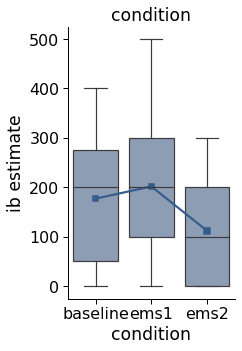

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [11]:
# with only stimulation condition
behavior_means = behavior.groupby(['id','condition'],as_index=False)['ed'].mean()

palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['baseline','random','EEG'] 
ylabel = 'ib estimate'
xlabel = 'condition'
title = 'condition'
data = behavior
data_means = behavior_means
y = "ed"
x = "condition"
hue = "id"


plot_3_cats(data, x, y, hue, ylabel, xlabel,cats,palette,data_means)

### plot both conditions

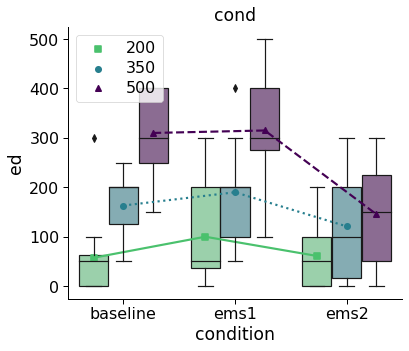

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [12]:
# with stimulation condition + time condition+ rd as y
behavior_means = behavior.groupby(['id','condition','rd'],as_index=False)['ed'].mean()


palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['baseline','ems1','ems2'] 
ylabel = 'ed'
xlabel = 'condition'
title = 'cond'
data = behavior
data_means = behavior_means
y = "ed"
x = "condition"
hue = "id"
hue2 = 'rd'


plot_3_cats_hue(data, x, y, hue, ylabel, xlabel,cats,palette,data_means,hue2)

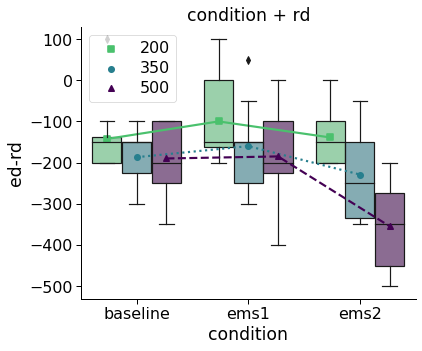

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [309]:
# with stimulation condition + time condition+ rd as y

behavior[['rd']] = behavior[['rd']].apply(pd.to_numeric, axis=1)
behavior["diff"]= behavior["ed"]-behavior["rd"]
behavior[['rd']] = behavior[['rd']].astype("category")


behavior_means = behavior.groupby(['id','condition','rd'],as_index=False)['diff'].mean()

palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['baseline','ems1','ems2'] 
ylabel = 'ed-rd'
xlabel = 'condition'
title = 'condition + rd'
data = behavior
data_means = behavior_means
y = "diff"
x = "condition"
hue = "id"
hue2 = 'rd'


plot_3_cats_hue(data, x, y, hue, ylabel, xlabel,cats,palette,data_means,hue2)

histogramm rt

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


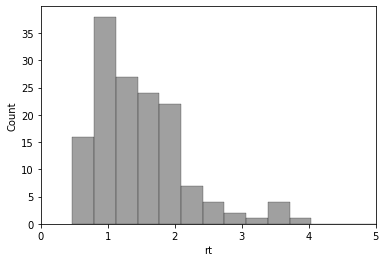

In [13]:

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'rt',color= 'grey',ax =ax)
ax.set_xlim(0,5) # remove outliers for visualization

hist.figure.savefig(d+'results/hist_rt.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
hist.figure.savefig(d+'results/hist_rt.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

### linear mixed model

#### prep
- witched from rpy2 to pymer4, because it is less annoying with importing / exporting from python to R
- not sure if of this is still necessary, but since pymer4 is based on rpy2, this might be the case

In [21]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x000001FB135ED800> [RTYPES.NILSXP]

In [25]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(packnames))
from pymer4.models import Lmer

R[write to console]: Installiere Pakete nach 'C:/Users/terfu/AppData/Local/R/win-library/4.2'
(da 'lib' nicht spezifiziert)



Exception ignored from cffi callback <function _consolewrite_ex at 0x000001FB13583D90>:
Traceback (most recent call last):
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 18: invalid continuation byte


:
     binary source needs_compilation
lme4 1.1-31 1.1-32              TRUE

  Binaries will be installed


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/lme4_1.1-31.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 4525485 bytes (4.3 MB)

R[write to console]: downloaded 4.3 MB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/lmerTest_3.1-3.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 531041 bytes (518 KB)

R[write to console]: downloaded 518 KB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/emmeans_1.8.5.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2160596 bytes (2.1 MB)

R[write to console]: downloaded 2.1 MB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/geepack_1.3.9.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 899170 bytes (878 KB)

R[write to console]: downloaded 878 KB



Paket 'lme4' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'lmerTest' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'emmeans' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'geepack' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'sjPlot' erfolgreich ausgepackt und MD5 Summen abgeglichen



Exception ignored from cffi callback <function _consolewrite_ex at 0x000001FB13583D90>:
Traceback (most recent call last):
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 25: invalid continuation byte


In [34]:
# does not run with one pID (RRuntimeError: Error: grouping factors must have > 1 sampled level)

full_model = Lmer('ed ~ condition * rd + (1|id)', data = behavior)
display(full_model.fit(REML = False,factors={"condition": ["baseline", "ems1", "ems2"], "rd": ["200", "350", "500"]}))
full_model.plot_summary()

RRuntimeError: Error: No random effects terms specified in formula


#### define null models

In [179]:
# null without interaction
null_model_int = Lmer('ed ~ condition + rd + (1|id)', data = behavior)
null_model_int.fit(REML = False, summarize=False)

# null model without stimulation condition 
null_model_stim = Lmer('ed ~ rd + (1|id)', data = behavior)
null_model_stim.fit(REML = False, summarize=False)

# null model without temp condition 
null_model_temp = Lmer('ed ~ condition + (1|id)', data = behavior)
null_model_temp.fit(REML = False, summarize=False)


#### liklyhood ratio tests
To DO: discussed before but: when we have a full model with interaction, 
what do we use as null models for liklyhood ration test? When we leave the interaction out compleatly,
 we can not use the ß estimates from the full model (Ithink)


interaction

In [88]:
pymer4.stats.lrt([null_model_int,full_model])


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,ib_estimate~stimulation_condition+temp_conditi...,7,600.552312,620.064754,-293.276156,586.552312,,,,
1,ib_estimate~stimulation_condition*temp_conditi...,11,608.041035,638.703444,-293.020517,586.041035,0.511277,4.0,0.972394,


stimulation condition

In [89]:
pymer4.stats.lrt([null_model_stim,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,ib_estimate~temp_condition+(1|pID),5,687.382420,701.319879,-338.691210,677.382420,,,,
1,ib_estimate~stimulation_condition*temp_conditi...,11,608.041035,638.703444,-293.020517,586.041035,91.341385,6.0,0.0,***


temp condition

In [90]:
pymer4.stats.lrt([null_model_temp,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,ib_estimate~temp_condition+(1|pID),5,687.382420,701.319879,-338.691210,677.382420,,,,
1,ib_estimate~stimulation_condition*temp_conditi...,11,608.041035,638.703444,-293.020517,586.041035,91.341385,6.0,0.0,***


#### post hoc test

TODO check wether this post_hoc test is correct

In [186]:
# post hoc test stimulation condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="condition",p_adjust = "bonf")

print(comparisons)


P-values adjusted by bonf method for 3 comparisons
            Contrast  Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val  \
1     baseline - eeg     4.208   2.736    5.680  0.606  118.0   6.944    0.0   
2  baseline - random     7.009   5.537    8.481  0.606  118.0  11.565    0.0   
3       eeg - random     2.801   1.329    4.273  0.606  118.0   4.622    0.0   

   Sig  
1  ***  
2  ***  
3  ***  


In [187]:
# post hoc test stimulation condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="rd",p_adjust = "bonf")

print(comparisons)

P-values adjusted by bonf method for 3 comparisons
        Contrast  Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val Sig
1  rd200 - rd250    -0.086  -1.524    1.352  0.592  118.0  -0.145    1.0    
2  rd200 - rd500     0.220  -1.218    1.658  0.592  118.0   0.371    1.0    
3  rd250 - rd500     0.306  -1.232    1.843  0.633  118.0   0.483    1.0    


# 2. EEG Data

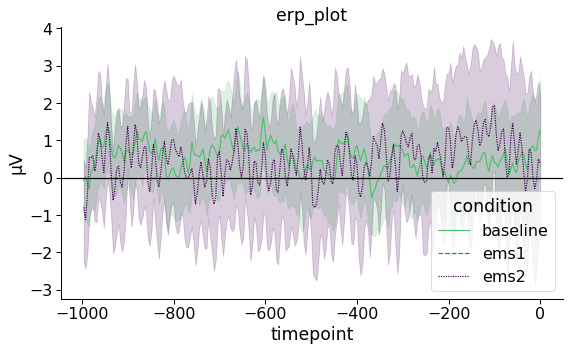

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [16]:
eeg_data = pd.read_csv( p +'PI_results.csv')

data = eeg_data
id_vars = ['id','condition','tr_nr','rd','ed']
delete_vars = 'rt' # metrics that are not erp
sample_rate = 250
window_start = -1000 
hue = 'condition'
palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
title = 'erp_plot'

plot_erp_timeline(data,id_vars,delete_vars,sample_rate,window_start,hue,palette,title)



# 2. Questionaire results
- items per block "„Während der Aufgabe hat es sich angefühlt, als hätte ich die Kontrolle über die Bewegungen.“
- input pid|first_block|control_random|control_EEG|expectation_fit|embodiment
- paired t-testsf
- box plots
- SD,M,effect size

@ Lukas? Significance test mit 5 values ist wirklich etwas shady, oder?

In [26]:
pp

'C://Users/terfu/Desktop/2021-fastReach/data/study/'

In [23]:
#laod fake data
questionaire= pd.read_csv('fake_data/subjective_fastReach.csv', sep = ';')

In [30]:
questionaire= pd.read_excel(pp + 'questionaire.xlsx') #read from repository


c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


### plot control

control_agency vs. control_random: Custom statistical test, P_val:nan


c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


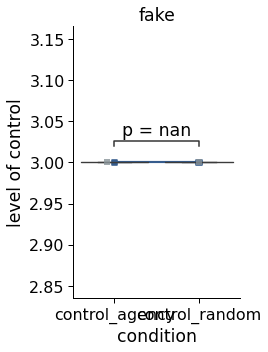

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [33]:
questionaire_long = questionaire.melt(id_vars= ['pID'],value_vars=['control_agency','control_random'])

palette = ['#365c8d','#E5E4E2','#899499','#4ac16d', '#277f8e','#440154'] 
cats= ['control_random', 'control_agency']
ylabel = 'level of control'
xlabel = 'condition'
title = 'fake'
data = questionaire_long
y = "value"
x = "variable"
hue = "pID"

plot_2_cats(data, x, y, hue, ylabel, xlabel,cats,palette)

#cohend(data,x,y, cats)

### numbers control

In [34]:
questionaire_long.groupby('variable')['value'].agg(["mean", "std"])


,mean,std
variable,,
control_agency,3.0,NaN
control_random,3.0,NaN


### count expectation

In [35]:
questionaire['expectation_fit'].value_counts()

KeyError: 'expectation_fit'

### count embodiment

In [108]:
questionaire['embodiment'].value_counts()

nein    11
ja      11
Name: embodiment, dtype: int64

# 3. Content Analysis
- built to world clouds for each block
- define stopwords
- maybe check sentiment analysis -> pareid t-test?
-TODO: try word cloud german


In [459]:
interview_random_text = questionaire['interview_random'].to_json()

interview_eeg_text = questionaire['interview_EEG'].to_json()

stopwords = STOPWORDS # extend by domaine specific words if necessary



In [460]:
wc_formate = WordCloud(background_color='black', max_words=500, width=3000,
                    height=1500, stopwords=stopwords, min_font_size=2,
                    contour_width=3, contour_color='white')

wc_formate.generate(interview_random_text)
wc_formate.to_file((d+"results/wordcloud_random.png"))

wc_formate.generate(interview_eeg_text)
wc_formate.to_file((d+"results/wordcloud_eeg.png"))


# 4. Sentiment Analysis

In [463]:
# for whole text

analyzer=SentimentIntensityAnalyzer()  

print(analyzer.polarity_scores(interview_random_text))
print(analyzer.polarity_scores(interview_eeg_text))



{'neg': 0.049, 'neu': 0.809, 'pos': 0.142, 'compound': 0.9846}
{'neg': 0.104, 'neu': 0.735, 'pos': 0.161, 'compound': 0.9879}
